In [1]:
!mkdir data
!cd data && curl -L -o egyptian_fruit_bats.zip https://archive.org/download/egyptian_fruit_bats_10k/egyptian_fruit_bats.zip
!cd data && unzip -q egyptian_fruit_bats.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 5003M  100 5003M    0     0  4714k      0  0:18:06  0:18:06 --:--:-- 11.3M


In [2]:
import pandas as pd
import librosa
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import torch
from __future__ import annotations
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from sklearn.cluster import KMeans
from typing import Dict, List, cast, Tuple, Optional
import math
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

sns.set_theme(context="notebook", style="whitegrid")



ROOT: /content


In [10]:
ROOT = Path.cwd().resolve()  # launched kernel in starter_code/
DATA_DIR = ROOT / "data"
DERIVED_DIR = ROOT / "derived"
AUDIO_DIR = DATA_DIR / "audio"
DERIVED_AUDIO_48K = DERIVED_DIR / "audio_48k"
DERIVED_MELS_48K = DERIVED_DIR / "mels_48k"

DERIVED_DIR.mkdir(exist_ok=True)
DERIVED_AUDIO_48K.mkdir(exist_ok=True, parents=True)
DERIVED_MELS_48K.mkdir(exist_ok=True, parents=True)

MELS_48K_DIR = DERIVED_DIR / 'mels_48k'
TOKENS_DIR = DERIVED_DIR / 'tokens'
AST_DIR = DERIVED_DIR / 'ast_features'

TOKENS_DIR.mkdir(exist_ok=True, parents=True)
AST_DIR.mkdir(exist_ok=True, parents=True)

KMEANS_DIR = TOKENS_DIR / "k_means"
KMEANS_RLE_DIR = TOKENS_DIR / "k_means_rle"
VQ_TOKENS_DIR = TOKENS_DIR / "vqvae"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE: ", device)
print("ROOT: ", ROOT)

# should be starter_code/
print("ROOT:", ROOT)

DEVICE:  cuda
ROOT:  /content
ROOT: /content


In [4]:
anno = pd.read_csv('data/annotations.csv')
# Load annotations: 10k subset and full annotations with richer labels
ann_small = pd.read_csv(DATA_DIR / "annotations.csv")
ann_full = pd.read_csv(DATA_DIR / "annotations_filenames.csv")

print("ann_small shape:", ann_small.shape)
print("ann_full shape :", ann_full.shape)

# Merge to bring richer labels onto the 10k subset (join on Emitter + File Name)
ann = ann_small.merge(
    ann_full,
    on=["Emitter", "File Name"],
    how="left",
)

print("Merged shape (10k with full labels):", ann.shape)
missing_fileid = ann['FileID'].isna().sum() if 'FileID' in ann.columns else 0
print("Rows with missing FileID after merge:", missing_fileid)
print(len(ann)) # should be 10000
ann.head() # should have all columns along with file name

ann.to_csv(DATA_DIR / "annotations_10k.csv", index=False)
print("Wrote annotations_10k.csv with shape:", ann.shape)

ann_small shape: (10000, 2)
ann_full shape : (91080, 11)
Merged shape (10k with full labels): (10000, 11)
Rows with missing FileID after merge: 0
10000
Wrote annotations_10k.csv with shape: (10000, 11)


In [5]:
TARGET_SR = 48_000

def resample_file(src: Path, dst: Path, target_sr: int = TARGET_SR) -> None:
    if dst.exists():
        return
    y, sr = librosa.load(src, sr=None)
    if sr == target_sr:
        y_resampled = y
    else:
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    sf.write(dst, y_resampled, target_sr)

for fn in ann_small['File Name']:
    src = AUDIO_DIR / fn
    dst = DERIVED_AUDIO_48K / fn
    if not src.exists():
        continue
    resample_file(src, dst)

len(list(DERIVED_AUDIO_48K.glob('*.wav')))

10000

In [16]:
N_MELS = 80
HOP_LENGTH = 512
N_FFT = 2048

def compute_mel_power(path: Path) -> np.ndarray:
    y, sr = librosa.load(path, sr=None)
    mel_power = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, fmax=sr // 2
    )
    return mel_power.astype(np.float32)


for fn in ann_small['File Name']:
    src = DERIVED_AUDIO_48K / fn if (DERIVED_AUDIO_48K / fn).exists() else AUDIO_DIR / fn
    if not src.exists():
        continue
    out_path = DERIVED_MELS_48K / (Path(fn).stem + '.npy')
    if out_path.exists():
        continue
    mel = compute_mel_power(src)
    np.save(out_path, mel)

len(list(DERIVED_MELS_48K.glob('*.npy')))

10000

In [7]:
# NOTE from mahika: took about 12 min for me to run this cell
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import librosa

W2V_MODEL_NAME = 'facebook/wav2vec2-base'  # or a HuBERT variant

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(W2V_MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

w2v_model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME).to(device)

w2v_model.eval()


ann_small = pd.read_csv(DATA_DIR / 'annotations.csv')

# NOTE: can change target_sr to 48_000 or something else to not downsample as much
def load_audio_for_w2v(path: Path, target_sr: int = 16_000) -> np.ndarray:
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y.astype(np.float32)

def extract_w2v_embeddings(wav: np.ndarray, sr: int = 16_000) -> np.ndarray:
    inputs = feature_extractor(wav, sampling_rate=sr, return_tensors='pt')
    with torch.no_grad():
        out = w2v_model(inputs.input_values.to(device))
    # shape: (1, T, hidden_size)
    return out.last_hidden_state.squeeze(0).cpu().numpy()

# Example: extract embeddings for a small subset of files, or all files
subset = ann_small['File Name'].iloc[:None]
all_frames: List[np.ndarray] = []
file2frame_indices: Dict[str, slice] = {}
start = 0

for idx, fn in enumerate(subset):
    path = AUDIO_DIR / fn
    if not path.exists():
        continue
    wav = load_audio_for_w2v(path)
    emb = extract_w2v_embeddings(wav)  # (T, D)
    end = start + emb.shape[0]
    all_frames.append(emb)
    file2frame_indices[fn] = slice(start, end)
    start = end
    print(f"Processed {idx+1}/{len(subset)} files")

frame_matrix = np.concatenate(all_frames, axis=0)  # (total_T, D)
frame_matrix.shape # (931105, 768)

# 931,105: total number of time frames across all processed audio files
#       (i.e., concatenating each file’s wav2vec2 frame sequence end‑to‑end)
# 768: the embedding dimension of the wav2vec2 model
#       (facebook/wav2vec2-base outputs 768‑dimensional vectors per frame)
# So frame_matrix is a big 2D array of all frame‑level embeddings:
# each row is one frame, each column is one embedding feature.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Processed 1/10000 files
Processed 2/10000 files
Processed 3/10000 files
Processed 4/10000 files


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processed 5001/10000 files
Processed 5002/10000 files
Processed 5003/10000 files
Processed 5004/10000 files
Processed 5005/10000 files
Processed 5006/10000 files
Processed 5007/10000 files
Processed 5008/10000 files
Processed 5009/10000 files
Processed 5010/10000 files
Processed 5011/10000 files
Processed 5012/10000 files
Processed 5013/10000 files
Processed 5014/10000 files
Processed 5015/10000 files
Processed 5016/10000 files
Processed 5017/10000 files
Processed 5018/10000 files
Processed 5019/10000 files
Processed 5020/10000 files
Processed 5021/10000 files
Processed 5022/10000 files
Processed 5023/10000 files
Processed 5024/10000 files
Processed 5025/10000 files
Processed 5026/10000 files
Processed 5027/10000 files
Processed 5028/10000 files
Processed 5029/10000 files
Processed 5030/10000 files
Processed 5031/10000 files
Processed 5032/10000 files
Processed 5033/10000 files
Processed 5034/10000 files
Processed 5035/10000 files
Proc

(931105, 768)

In [9]:
KMEANS_DIR = TOKENS_DIR / "k_means"
KMEANS_DIR.mkdir(exist_ok=True, parents=True)

# Fit k-means on frame-level embeddings to create a codebook
N_CLUSTERS = 128
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
kmeans.fit(frame_matrix)

# Convert each file's frames into a sequence of discrete token IDs
file2tokens: Dict[str, np.ndarray] = {}
for idx, (fn, sl) in enumerate(file2frame_indices.items()):
    frame_embs = frame_matrix[sl]
    tokens = kmeans.predict(frame_embs)
    tokens_arr = np.asarray(tokens, dtype=np.int16)
    file2tokens[fn] = tokens_arr
    np.save(KMEANS_DIR / f"w2v_kmeans_{Path(fn).stem}.npy", tokens_arr)
    print(f"Processed {idx+1}/{len(file2frame_indices)} files")

len(file2tokens)

Streaming output truncated to the last 5000 lines.
Processed 5001/10000 files
Processed 5002/10000 files
Processed 5003/10000 files
Processed 5004/10000 files
Processed 5005/10000 files
Processed 5006/10000 files
Processed 5007/10000 files
Processed 5008/10000 files
Processed 5009/10000 files
Processed 5010/10000 files
Processed 5011/10000 files
Processed 5012/10000 files
Processed 5013/10000 files
Processed 5014/10000 files
Processed 5015/10000 files
Processed 5016/10000 files
Processed 5017/10000 files
Processed 5018/10000 files
Processed 5019/10000 files
Processed 5020/10000 files
Processed 5021/10000 files
Processed 5022/10000 files
Processed 5023/10000 files
Processed 5024/10000 files
Processed 5025/10000 files
Processed 5026/10000 files
Processed 5027/10000 files
Processed 5028/10000 files
Processed 5029/10000 files
Processed 5030/10000 files
Processed 5031/10000 files
Processed 5032/10000 files
Processed 5033/10000 files
Processed 5034/10000 files
Processed 5035/10000 files
Proc

10000

In [11]:
import numpy as np

def rle_compress(tokens: np.ndarray) -> np.ndarray:
    """Run-length encode by keeping only token changes."""
    if len(tokens) == 0:
        return tokens
    keep = np.empty(len(tokens), dtype=bool)
    keep[0] = True
    keep[1:] = tokens[1:] != tokens[:-1]
    return tokens[keep]


In [12]:
import numpy as np
from pathlib import Path

# Where original k-means tokens are stored
KMEANS_DIR = TOKENS_DIR / "k_means"

# Where we will save RLE-compressed tokens
KMEANS_RLE_DIR = TOKENS_DIR / "k_means_rle"
KMEANS_RLE_DIR.mkdir(exist_ok=True, parents=True)

def rle_compress(tokens: np.ndarray) -> np.ndarray:
    """
    Run-length encoding: keep only token changes.
    [a, a, a, b, b, c] -> [a, b, c]
    """
    if len(tokens) == 0:
        return tokens
    keep = np.empty(len(tokens), dtype=bool)
    keep[0] = True
    keep[1:] = tokens[1:] != tokens[:-1]
    return tokens[keep]

# Process all existing k-means token files
token_files = sorted(KMEANS_DIR.glob("w2v_kmeans_*.npy"))
print(f"Found {len(token_files)} k-means token files")

for idx, tok_path in enumerate(token_files, start=1):
    tokens = np.load(tok_path)
    tokens_rle = rle_compress(tokens).astype(np.int16)

    stem = tok_path.stem.replace("w2v_kmeans_", "")
    out_path = KMEANS_RLE_DIR / f"w2v_kmeans_rle_{stem}.npy"
    np.save(out_path, tokens_rle)

    if idx % 100 == 0 or idx == len(token_files):
        print(f"[RLE] processed {idx}/{len(token_files)} files")

print("Done saving RLE-compressed tokens.")


Found 10000 k-means token files
[RLE] processed 100/10000 files
[RLE] processed 200/10000 files
[RLE] processed 300/10000 files
[RLE] processed 400/10000 files
[RLE] processed 500/10000 files
[RLE] processed 600/10000 files
[RLE] processed 700/10000 files
[RLE] processed 800/10000 files
[RLE] processed 900/10000 files
[RLE] processed 1000/10000 files
[RLE] processed 1100/10000 files
[RLE] processed 1200/10000 files
[RLE] processed 1300/10000 files
[RLE] processed 1400/10000 files
[RLE] processed 1500/10000 files
[RLE] processed 1600/10000 files
[RLE] processed 1700/10000 files
[RLE] processed 1800/10000 files
[RLE] processed 1900/10000 files
[RLE] processed 2000/10000 files
[RLE] processed 2100/10000 files
[RLE] processed 2200/10000 files
[RLE] processed 2300/10000 files
[RLE] processed 2400/10000 files
[RLE] processed 2500/10000 files
[RLE] processed 2600/10000 files
[RLE] processed 2700/10000 files
[RLE] processed 2800/10000 files
[RLE] processed 2900/10000 files
[RLE] processed 3000

In [163]:
TOKEN_TYPE = "kmeans"

def load_token_sequences(token_type: str = TOKEN_TYPE) -> Tuple[List[np.ndarray], int]:
    """Load all available token sequences and infer vocabulary size.

    Returns
    -------
    sequences : list of np.ndarray
        Each entry is a 1D int array of token IDs for one file.
    vocab_size : int
        Maximum token ID + 1 across all sequences (upper bound on vocabulary).
    """

    sequences: List[np.ndarray] = []
    max_token_id = -1

    if token_type == "kmeans":
        pattern = "w2v_kmeans_"
        base_dir = KMEANS_DIR
    elif token_type == "vqvae":
        pattern = "vqvae_"
        base_dir = VQ_TOKENS_DIR
    else:
        raise ValueError(f"Unsupported TOKEN_TYPE: {token_type}")

    if not base_dir.exists():
        raise FileNotFoundError(
            f"Token directory {base_dir} not found. Run 05_Tokenization_Strategies.ipynb first."
        )

    paths = sorted(base_dir.glob("*.npy"))
    if not paths:
        raise RuntimeError(f"No token files found in {base_dir}.")

    for p in paths:
        if pattern not in p.name:
            continue
        arr = np.load(p).astype(np.int64)
        if arr.ndim != 1 or arr.size < 2:
            continue
        max_token_id = max(max_token_id, int(arr.max()))
        sequences.append(arr)

    if not sequences:
        raise RuntimeError(f"No valid token sequences loaded from {base_dir}.")

    vocab_size = max_token_id + 1
    print(f"Loaded {len(sequences)} sequences from {base_dir} with vocab_size={vocab_size}.")
    return sequences, vocab_size


sequences, vocab_size = load_token_sequences(TOKEN_TYPE)
len(sequences), vocab_size

def load_token_sequences(token_type: str = TOKEN_TYPE) -> Tuple[List[np.ndarray], int]:
    """Load all available token sequences and infer vocabulary size.

    Returns
    -------
    sequences : list of np.ndarray
        Each entry is a 1D int array of token IDs for one file.
    vocab_size : int
        Maximum token ID + 1 across all sequences (upper bound on vocabulary).
    """

    sequences: List[np.ndarray] = []
    max_token_id = -1

    if token_type == "kmeans":
        pattern = "w2v_kmeans_"
        base_dir = KMEANS_DIR
    elif token_type == "vqvae":
        pattern = "vqvae_"
        base_dir = VQ_TOKENS_DIR
    else:
        raise ValueError(f"Unsupported TOKEN_TYPE: {token_type}")

    if not base_dir.exists():
        raise FileNotFoundError(
            f"Token directory {base_dir} not found. Run 05_Tokenization_Strategies.ipynb first."
        )

    paths = sorted(base_dir.glob("*.npy"))
    if not paths:
        raise RuntimeError(f"No token files found in {base_dir}.")

    for p in paths:
        if pattern not in p.name:
            continue
        arr = np.load(p).astype(np.int64)
        if arr.ndim != 1 or arr.size < 2:
            continue
        max_token_id = max(max_token_id, int(arr.max()))
        sequences.append(arr)

    if not sequences:
        raise RuntimeError(f"No valid token sequences loaded from {base_dir}.")

    vocab_size = max_token_id + 1
    print(f"Loaded {len(sequences)} sequences from {base_dir} with vocab_size={vocab_size}.")
    return sequences, vocab_size


sequences, vocab_size = load_token_sequences(TOKEN_TYPE)
len(sequences), vocab_size

class NextTokenDataset(Dataset):
    def __init__(
        self,
        sequences: List[np.ndarray],
        seq_len: int = 64,
        stride: int = 4,
    ) -> None:
        self.sequences = sequences
        self.seq_len = seq_len
        self.stride = max(1, stride)

        # precompute (sequence_idx, start) pairs
        indices: List[Tuple[int, int]] = []
        for si, seq in enumerate(sequences):
            n = len(seq)
            if n <= seq_len:
                continue
            # last start index that allows target to go up to t_{i+L}
            max_start = n - (seq_len + 1)
            if max_start < 0:
                continue
            for start in range(0, max_start + 1, self.stride):
                indices.append((si, start))

        if not indices:
            raise RuntimeError("No training windows could be formed. Try shorter seq_len or stride.")

        self.indices = indices
        print(f"Dataset: {len(self.indices)} windows, seq_len={self.seq_len}, stride={self.stride}.")

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        si, start = self.indices[idx]
        seq = self.sequences[si]
        x = torch.from_numpy(seq[start : start + self.seq_len]).long()
        y = torch.from_numpy(seq[start + 1 : start + 1 + self.seq_len]).long()
        return x, y


SEQ_LEN = 64
STRIDE = 4

# train/val split at the sequence level to avoid leakage
num_sequences = len(sequences)
val_frac = 0.1
num_val = max(1, int(num_sequences * val_frac))
num_train = num_sequences - num_val

all_indices = list(range(num_sequences))
rng = np.random.default_rng(42)
rng.shuffle(all_indices)
train_indices = all_indices[:num_train]
val_indices = all_indices[num_train:]

train_seqs = [sequences[i] for i in train_indices]
val_seqs = [sequences[i] for i in val_indices]

train_dataset = NextTokenDataset(train_seqs, seq_len=SEQ_LEN, stride=STRIDE)
val_dataset = NextTokenDataset(val_seqs, seq_len=SEQ_LEN, stride=STRIDE)

len(train_dataset), len(val_dataset)

class TransformerLM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,
        n_heads: int = 4,
        num_layers: int = 4,
        dim_feedforward: int = 512,
        max_seq_len: int = 256,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def _generate_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
        # (seq_len, seq_len) with True in upper-right triangle (masked positions)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)
        return mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Parameters
        ----------
        x : LongTensor of shape (batch, seq_len)

        Returns
        -------
        logits : FloatTensor of shape (batch, seq_len, vocab_size)
        """

        bsz, seq_len = x.shape
        if seq_len > self.max_seq_len:
            raise ValueError(f"seq_len={seq_len} exceeds max_seq_len={self.max_seq_len}")

        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(bsz, seq_len)
        h = self.token_emb(x) + self.pos_emb(positions)

        src_mask = self._generate_causal_mask(seq_len, device=x.device)
        h = self.encoder(h, mask=src_mask)
        h = self.ln_f(h)
        logits = self.head(h)
        return logits


model = TransformerLM(vocab_size=vocab_size, d_model=256, n_heads=4, num_layers=4, dim_feedforward=512, max_seq_len=SEQ_LEN).to(device)
model
BATCH_SIZE = 64
N_EPOCHS = 5
LR = 3e-4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)  # (B, L, V)
            B, L, V = logits.shape
            logits_flat = logits.view(B * L, V)
            y_flat = y.view(B * L)

            loss = criterion(logits_flat, y_flat)
            total_loss += loss.item() * (B * L)
            total_tokens += B * L

            preds = logits_flat.argmax(dim=-1)
            correct += (preds == y_flat).sum().item()

    avg_loss = total_loss / max(1, total_tokens)
    acc = correct / max(1, total_tokens)
    return avg_loss, acc


best_val_loss = float("inf")

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_tokens = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        B, L, V = logits.shape
        loss = criterion(logits.view(B * L, V), y.view(B * L))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * (B * L)
        running_tokens += B * L

    train_loss = running_loss / max(1, running_tokens)
    val_loss, val_acc = evaluate(model, val_loader)
    val_ppl = math.exp(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}/{N_EPOCHS} - train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_ppl={val_ppl:.2f} | val_acc={val_acc:.4f}")

# can load best model state
if 'best_state' in globals():
    model.load_state_dict(best_state)
    model.to(device)
    print("Loaded best model state (by val loss).")

Loaded 10000 sequences from /content/derived/tokens/k_means with vocab_size=128.
Loaded 10000 sequences from /content/derived/tokens/k_means with vocab_size=128.
Dataset: 71935 windows, seq_len=64, stride=4.
Dataset: 7637 windows, seq_len=64, stride=4.
Epoch 1/5 - train_loss=1.8725 | val_loss=1.6730 | val_ppl=5.33 | val_acc=0.4887
Epoch 2/5 - train_loss=1.6707 | val_loss=1.6415 | val_ppl=5.16 | val_acc=0.4916
Epoch 3/5 - train_loss=1.6317 | val_loss=1.6331 | val_ppl=5.12 | val_acc=0.4923
Epoch 4/5 - train_loss=1.6027 | val_loss=1.6347 | val_ppl=5.13 | val_acc=0.4906
Epoch 5/5 - train_loss=1.5768 | val_loss=1.6381 | val_ppl=5.15 | val_acc=0.4907
Loaded best model state (by val loss).


In [15]:
import math
import numpy as np
from pathlib import Path
from typing import List, Tuple
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import librosa
import soundfile as sf


# ============================================================
# 0) AUDIO SETTINGS (match your preprocessing)
# ============================================================
SR = 48_000
N_MELS = 80
HOP_LENGTH = 512
N_FFT = 2048

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1) VQ (EMA) — unchanged
# ============================================================
class VectorQuantizerEMA(nn.Module):
    def __init__(
        self,
        num_codes: int,
        code_dim: int,
        beta: float = 0.25,
        decay: float = 0.99,
        eps: float = 1e-5,
    ) -> None:
        super().__init__()
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.beta = beta
        self.decay = decay
        self.eps = eps

        embed = torch.empty(num_codes, code_dim)
        nn.init.uniform_(embed, -1.0 / math.sqrt(code_dim), 1.0 / math.sqrt(code_dim))
        self.register_buffer("embed", embed)                           # (K, D)
        self.register_buffer("cluster_size", torch.zeros(num_codes))   # (K,)
        self.register_buffer("embed_avg", embed.clone())               # (K, D)

    @torch.no_grad()
    def _ema_update(self, flat_z: torch.Tensor, flat_codes: torch.Tensor) -> None:
        K = self.num_codes
        onehot = F.one_hot(flat_codes, num_classes=K).type_as(flat_z)  # (N, K)
        new_cluster_size = onehot.sum(dim=0)                           # (K,)
        new_embed_sum = onehot.t() @ flat_z                            # (K, D)

        self.cluster_size.mul_(self.decay).add_(new_cluster_size, alpha=1.0 - self.decay)
        self.embed_avg.mul_(self.decay).add_(new_embed_sum, alpha=1.0 - self.decay)

        n = self.cluster_size.sum()
        cluster_size = (self.cluster_size + self.eps) / (n + K * self.eps) * n
        self.embed.copy_(self.embed_avg / cluster_size.unsqueeze(1))

    def forward(self, z: torch.Tensor):
        B, C, H, W = z.shape
        assert C == self.code_dim, f"Expected C==code_dim ({self.code_dim}), got C={C}"

        z_hw_c = z.permute(0, 2, 3, 1).contiguous()  # (B, H, W, C)
        flat_z = z_hw_c.view(-1, C)                  # (N, C)

        embed = self.embed
        flat_z_sq = (flat_z ** 2).sum(dim=1, keepdim=True)
        embed_sq = (embed ** 2).sum(dim=1).unsqueeze(0)
        distances = flat_z_sq - 2.0 * (flat_z @ embed.t()) + embed_sq  # (N, K)

        flat_codes = distances.argmin(dim=1)      # (N,)
        codes = flat_codes.view(B, H * W)         # (B, H*W)

        z_q = embed[flat_codes].view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

        if self.training:
            self._ema_update(flat_z, flat_codes)

        commitment_loss = F.mse_loss(z_q.detach(), z, reduction="mean")
        vq_loss = self.beta * commitment_loss

        z_q_st = z + (z_q - z).detach()

        with torch.no_grad():
            counts = torch.bincount(flat_codes, minlength=self.num_codes).float()
            probs = counts / counts.sum().clamp_min(1.0)
            perplexity = torch.exp(-(probs[probs > 0] * torch.log(probs[probs > 0])).sum()).item()

        return z_q_st, codes, vq_loss, perplexity


# ============================================================
# 2) VQ-VAE — unchanged
# ============================================================
class SimpleVQVAE(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        code_dim: int = 64,
        num_codes: int = 128,
        beta: float = 0.25,
        decay: float = 0.99,
        vq_weight: float = 0.10,
    ):
        super().__init__()
        self.vq_weight = vq_weight

        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.ReLU(inplace=True),
        )

        self.pre_vq = nn.Conv2d(hidden_dim, code_dim, kernel_size=1)
        self.vq = VectorQuantizerEMA(num_codes=num_codes, code_dim=code_dim, beta=beta, decay=decay)
        self.post_vq = nn.Conv2d(code_dim, hidden_dim, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden_dim, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor):
        z_e = self.pre_vq(self.encoder(x))
        z_q, codes, vq_loss, perplexity = self.vq(z_e)
        z_q = self.post_vq(z_q)

        recon = self.decoder(z_q)
        recon = recon[:, :, : x.size(2), : x.size(3)]

        recon_loss = F.mse_loss(recon, x, reduction="mean")
        loss = recon_loss + self.vq_weight * vq_loss
        return recon, codes, loss, recon_loss, vq_loss, perplexity


# ============================================================
# 3) DATA — PRESERVE YOUR WORKING NORMALIZATION
#    (per-file mean/std z-score)
# ============================================================
class MelDataset(Dataset):
    """
    Expects each .npy is mel POWER, shape (F, T).
    We keep your original per-file z-score normalization.
    """
    def __init__(self, mels_dir: Path, file_names: List[str]):
        self.mel_paths = [mels_dir / (Path(fn).stem + ".npy") for fn in file_names]
        self.mel_paths = [p for p in self.mel_paths if p.exists()]

    def __len__(self) -> int:
        return len(self.mel_paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        mel = np.load(self.mel_paths[idx]).astype(np.float32)  # (F, T) mel power
        m = float(mel.mean())
        s = float(mel.std())
        mel = (mel - m) / (s + 1e-6)
        return torch.from_numpy(mel).float()  # (F, T)


def make_collate_patch(patch_T: int = 256):
    def collate(batch: List[torch.Tensor]) -> torch.Tensor:
        xs = []
        for mel in batch:
            Freq, T = mel.shape
            if T < patch_T:
                pad = torch.zeros(Freq, patch_T - T, dtype=mel.dtype)
                melp = torch.cat([mel, pad], dim=1)
            else:
                start = torch.randint(0, T - patch_T + 1, (1,)).item()
                melp = mel[:, start : start + patch_T]
            xs.append(melp)

        x = torch.stack(xs, dim=0)          # (B, F, patch_T)
        x = x.permute(0, 2, 1).contiguous() # (B, patch_T, F)
        x = x.unsqueeze(1)                  # (B, 1, patch_T, F)
        return x
    return collate


# ============================================================
# 4) TRAIN — same as you had
# ============================================================
all_fns = ann_small["File Name"].tolist()
mel_ds = MelDataset(MELS_48K_DIR, all_fns)

PATCH_T = 256
BATCH_SIZE = 16
LOG_INTERVAL = 200
NUM_EPOCHS = 10

mel_dl = DataLoader(
    mel_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate_patch(PATCH_T),
)

vqvae = SimpleVQVAE(
    hidden_dim=128,
    code_dim=64,
    num_codes=128,
    beta=0.25,
    decay=0.99,
    vq_weight=0.10,
).to(device)

opt = torch.optim.AdamW(vqvae.parameters(), lr=1e-4, weight_decay=1e-4)

print(
    f"Training VQ-VAE(EMA) on {len(mel_ds)} mels for {NUM_EPOCHS} epochs. "
    f"PATCH_T={PATCH_T}, BATCH_SIZE={BATCH_SIZE}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    vqvae.train()
    running = 0.0
    interval = 0.0
    usage = Counter()

    for step, x in enumerate(mel_dl, start=1):
        x = x.to(device)

        recon, codes, loss, recon_loss, vq_loss, perplexity = vqvae(x)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vqvae.parameters(), max_norm=1.0)
        opt.step()

        running += loss.item()
        interval += loss.item()
        usage.update(codes.view(-1).detach().cpu().tolist())

        if step % LOG_INTERVAL == 0:
            uniq_batch = torch.unique(codes).numel()
            uniq_seen = len(usage)
            print(
                f"[epoch {epoch}] step {step}: "
                f"interval_loss={interval/LOG_INTERVAL:.4f} "
                f"(recon={recon_loss.item():.4f}, vq={vq_loss.item():.4f}) "
                f"| perplexity={perplexity:.2f} "
                f"| uniq_batch={uniq_batch} uniq_seen={uniq_seen}"
            )
            interval = 0.0

    mean_loss = running / max(1, step)
    print(f"Finished epoch {epoch}/{NUM_EPOCHS} - mean loss {mean_loss:.4f} | codes_used_epoch={len(usage)}")


# ============================================================
# 5) SAVE CODES + SHAPE + (mean,std) USED FOR THAT FILE
#    Also save a dataset-level fallback (mean,std) for generated clips.
# ============================================================
vq_tokens_dir = TOKENS_DIR / "vqvae"
vq_tokens_dir.mkdir(exist_ok=True, parents=True)

vqvae.eval()
print(f"Saving VQ-VAE codes for {len(all_fns)} files into {vq_tokens_dir} ...")

means = []
stds = []

with torch.no_grad():
    for idx, fn in enumerate(all_fns, start=1):
        mel_path = MELS_48K_DIR / (Path(fn).stem + ".npy")
        if not mel_path.exists():
            continue

        mel = np.load(mel_path).astype(np.float32)  # (F, T) mel power
        m = float(mel.mean())
        s = float(mel.std())
        means.append(m)
        stds.append(s)

        mel_norm = (mel - m) / (s + 1e-6)

        x = torch.from_numpy(mel_norm).float()            # (F, T)
        x = x.permute(1, 0).unsqueeze(0).unsqueeze(0)     # (1, 1, T, F)
        x = x.to(device)

        z_e = vqvae.pre_vq(vqvae.encoder(x))
        _, _, H, W = z_e.shape

        _, codes, *_ = vqvae.vq(z_e)                      # (1, H*W)
        codes_np = codes.squeeze(0).cpu().numpy().astype(np.int16)

        stem = Path(fn).stem
        np.save(vq_tokens_dir / f"vqvae_{stem}_codes.npy", codes_np)
        np.save(vq_tokens_dir / f"vqvae_{stem}_shape.npy", np.array([H, W], dtype=np.int16))
        np.save(vq_tokens_dir / f"vqvae_{stem}_norm.npy",  np.array([m, s], dtype=np.float32))

        if idx % 500 == 0 or idx == len(all_fns):
            print(f"[vqvae codes] processed {idx}/{len(all_fns)} files")

# fallback stats for generated samples (no per-file mean/std exists)
fallback_mean = float(np.mean(means)) if means else 0.0
fallback_std  = float(np.mean(stds))  if stds  else 1.0
np.save(vq_tokens_dir / "fallback_mean_std.npy", np.array([fallback_mean, fallback_std], dtype=np.float32))
print("Saved fallback_mean_std:", fallback_mean, fallback_std)


# ============================================================
# 6) DECODE: codes -> mel_norm -> mel_power -> audio (Griffin-Lim)
# ============================================================
@torch.no_grad()
def decode_codes_to_mel_norm(vqvae: SimpleVQVAE, codes_1d: np.ndarray, H: int, W: int) -> np.ndarray:
    """
    Returns reconstructed mel in the SAME normalized space the VQ-VAE trained on.
    Output shape: (T, F) after squeezing/cropping.
    """
    dev = next(vqvae.parameters()).device
    vqvae.eval()

    codes_flat = torch.from_numpy(codes_1d.astype(np.int64)).to(dev)   # (H*W,)
    z_q = vqvae.vq.embed[codes_flat]                                   # (H*W, code_dim)
    z_q = z_q.view(1, H, W, -1).permute(0, 3, 1, 2).contiguous()       # (1, code_dim, H, W)

    z_q = vqvae.post_vq(z_q)
    recon = vqvae.decoder(z_q)                                         # (1,1,~4H,~4W)

    recon_tf = recon.squeeze(0).squeeze(0).detach().cpu().numpy()      # (T, F) approx
    return recon_tf


def mel_norm_to_mel_power(mel_norm_tf: np.ndarray, mean: float, std: float) -> np.ndarray:
    """
    mel_norm_tf: (T, F) normalized mel-power
    returns mel_power: (F, T) nonnegative
    """
    mel_power_tf = mel_norm_tf * (std + 1e-6) + mean
    mel_power_tf = np.maximum(mel_power_tf, 1e-8)
    return mel_power_tf.T  # (F, T)


def mel_power_to_audio_griffinlim(mel_power: np.ndarray) -> np.ndarray:
    """
    mel_power: (n_mels, T) in linear power
    """
    stft_mag = librosa.feature.inverse.mel_to_stft(
        mel_power,
        sr=SR,
        n_fft=N_FFT,
        power=2.0,
        fmin=0.0,
        fmax=SR / 2,
    )
    y = librosa.griffinlim(stft_mag, hop_length=HOP_LENGTH, win_length=N_FFT)
    return y


def save_audio_from_codes(stem: str, out_wav: str):
    codes = np.load(vq_tokens_dir / f"vqvae_{stem}_codes.npy")
    H, W = np.load(vq_tokens_dir / f"vqvae_{stem}_shape.npy").astype(int).tolist()

    # use per-file mean/std if available; otherwise fallback
    norm_path = vq_tokens_dir / f"vqvae_{stem}_norm.npy"
    if norm_path.exists():
        mean, std = np.load(norm_path).astype(np.float32).tolist()
    else:
        mean, std = np.load(vq_tokens_dir / "fallback_mean_std.npy").astype(np.float32).tolist()

    mel_norm_tf = decode_codes_to_mel_norm(vqvae, codes, H, W)     # (T, F)
    mel_power = mel_norm_to_mel_power(mel_norm_tf, mean, std)      # (F, T)

    y = mel_power_to_audio_griffinlim(mel_power)
    sf.write(out_wav, y, SR)
    print("Wrote:", out_wav)


# Example (reconstruct an existing file)
# stem = Path(all_fns[0]).stem
# save_audio_from_codes(stem, f"/content/recon_{stem}.wav")


Training VQ-VAE(EMA) on 10000 mels for 10 epochs. PATCH_T=256, BATCH_SIZE=16
[epoch 1] step 200: interval_loss=0.1321 (recon=0.0911, vq=0.0701) | perplexity=9.33 | uniq_batch=18 uniq_seen=40
[epoch 1] step 400: interval_loss=0.0843 (recon=0.0623, vq=0.0935) | perplexity=8.69 | uniq_batch=19 uniq_seen=40
[epoch 1] step 600: interval_loss=0.0777 (recon=0.0652, vq=0.1105) | perplexity=9.67 | uniq_batch=20 uniq_seen=40
Finished epoch 1/10 - mean loss 0.0973 | codes_used_epoch=40
[epoch 2] step 200: interval_loss=0.0757 (recon=0.0644, vq=0.1348) | perplexity=9.59 | uniq_batch=22 uniq_seen=22
[epoch 2] step 400: interval_loss=0.0742 (recon=0.0515, vq=0.1200) | perplexity=23.64 | uniq_batch=62 uniq_seen=62
[epoch 2] step 600: interval_loss=0.0631 (recon=0.0462, vq=0.1303) | perplexity=28.07 | uniq_batch=128 uniq_seen=128
Finished epoch 2/10 - mean loss 0.0706 | codes_used_epoch=128
[epoch 3] step 200: interval_loss=0.0591 (recon=0.0466, vq=0.1270) | perplexity=50.94 | uniq_batch=128 uniq_seen

In [42]:
# ============================================================
# AUDIO SETTINGS (must match mel creation)
# ============================================================
SR = 48_000
N_FFT = 2048
HOP_LENGTH = 512
N_ITER = 64          # more iterations = fewer artifacts

# ============================================================
# Helpers
# ============================================================
def maybe_db_to_power(mel_rep_ft: np.ndarray) -> np.ndarray:
    """
    mel_rep_ft: (F, T) either in dB (typically mostly negative) or already in linear power.
    Returns linear power mel: (F, T)
    """
    mel_rep_ft = mel_rep_ft.astype(np.float32, copy=False)
    # Heuristic: dB mel spectrograms are usually negative with median well below 0
    if float(np.nanmedian(mel_rep_ft)) < -10.0:
        mel_power_ft = librosa.db_to_power(mel_rep_ft, ref=1.0)  # power = 10**(dB/10)
    else:
        mel_power_ft = mel_rep_ft
    return np.maximum(mel_power_ft, 1e-8).astype(np.float32)


@torch.no_grad()
def decode_codes_to_mel_norm_tf(vqvae, codes_1d: np.ndarray, H: int, W: int) -> np.ndarray:
    """
    Decode VQ codes into the VQ-VAE's reconstruction space (normalized mel).
    codes_1d: length H*W
    Returns: mel_norm_tf (T, F)
    """
    vqvae.eval()
    dev = next(vqvae.parameters()).device

    codes = np.asarray(codes_1d, dtype=np.int64).reshape(-1)
    if codes.size != H * W:
        raise ValueError(f"codes_1d must have length H*W={H*W}, got {codes.size}")

    codes_t = torch.from_numpy(codes).to(dev)                  # (H*W,)
    z_q = vqvae.vq.embed[codes_t]                              # (H*W, code_dim)
    z_q = z_q.view(1, H, W, -1).permute(0, 3, 1, 2).contiguous()  # (1, code_dim, H, W)

    z_q = vqvae.post_vq(z_q)
    recon = vqvae.decoder(z_q)                                # (1, 1, ~4H, ~4W)

    mel_norm_tf = recon.squeeze(0).squeeze(0).detach().cpu().numpy()  # (T, F)
    return mel_norm_tf.astype(np.float32, copy=False)


def unnormalize_mel_norm_tf_to_rep_ft(mel_norm_tf: np.ndarray, mean: float, std: float) -> np.ndarray:
    """
    mel_norm_tf: (T, F) normalized
    Returns mel_rep_ft: (F, T) in the original mel representation space used to build the dataset.
    """
    mel_rep_tf = mel_norm_tf * (std + 1e-6) + mean  # (T, F)
    return mel_rep_tf.T.astype(np.float32, copy=False)  # (F, T)


def mel_power_to_audio(mel_power_ft: np.ndarray) -> np.ndarray:
    """
    Robust mel->audio path (mel_to_audio does mel_to_stft + griffinlim).
    mel_power_ft: (F, T) linear power
    """
    y = librosa.feature.inverse.mel_to_audio(
        mel_power_ft,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=N_FFT,
        power=2.0,
        n_iter=N_ITER,
        fmin=0.0,
        fmax=SR / 2,
    ).astype(np.float32, copy=False)

    # normalize to prevent "quiet then clipped transient"
    m = float(np.max(np.abs(y))) if y.size else 0.0
    if m > 0:
        y = 0.95 * (y / m)
    return y


# ============================================================
# Main: tokens -> wav
# ============================================================
def tokens_to_wav(
    vqvae,
    tokens_1d: np.ndarray,
    out_wav: str,
    H: int,
    W: int,
    fallback_mean_std_path: Path,
    debug: bool = True,
):
    """
    tokens_1d: generated tokens (length >= H*W). Uses first H*W.
    Writes a wav file to out_wav.
    """
    ms = np.load(fallback_mean_std_path).astype(np.float32)
    mean, std = float(ms[0]), float(ms[1])

    tokens = np.asarray(tokens_1d, dtype=np.int64).reshape(-1)
    if tokens.size < H * W:
        raise ValueError(f"Need at least H*W={H*W} tokens, got {tokens.size}.")
    codes = tokens[: H * W]

    mel_norm_tf = decode_codes_to_mel_norm_tf(vqvae, codes, H, W)            # (T, F)
    mel_rep_ft  = unnormalize_mel_norm_tf_to_rep_ft(mel_norm_tf, mean, std) # (F, T) in rep space
    mel_power_ft = maybe_db_to_power(mel_rep_ft)                              # (F, T) linear power

    if debug:
        print("mel_norm_tf:", float(mel_norm_tf.min()), float(mel_norm_tf.max()),
              float(mel_norm_tf.mean()), float(mel_norm_tf.std()))
        print("mel_rep_ft :", float(mel_rep_ft.min()), float(mel_rep_ft.max()),
              float(mel_rep_ft.mean()), float(mel_rep_ft.std()))
        print("mel_power_ft:", float(mel_power_ft.min()), float(mel_power_ft.max()),
              float(mel_power_ft.mean()), float(mel_power_ft.std()))

    y = mel_power_to_audio(mel_power_ft)
    sf.write(out_wav, y, SR)
    print("Wrote:", out_wav, "| seconds:", len(y) / SR)


In [ ]:
# choose which tokenization to use for the LM: "kmeans" or "vqvae"
TOKEN_TYPE = "vqvae"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("ROOT:", ROOT)
print("Using tokenization:", TOKEN_TYPE)

In [18]:
def load_vqvae_code_sequences(vq_tokens_dir: Path) -> Tuple[List[np.ndarray], int]:
    """
    Loads ONLY *_codes.npy as 1D token sequences.
    Returns (sequences, vocab_size).
    """
    paths = sorted(vq_tokens_dir.glob("*_codes.npy"))
    if not paths:
        raise RuntimeError(f"No *_codes.npy files found in {vq_tokens_dir}")

    seqs: List[np.ndarray] = []
    max_token = -1

    for p in paths:
        arr = np.load(p)
        arr = np.asarray(arr).reshape(-1).astype(np.int64, copy=False)
        if arr.size < 2:
            continue
        max_token = max(max_token, int(arr.max()))
        seqs.append(arr)

    if not seqs:
        raise RuntimeError("No valid code sequences loaded (all too short?).")

    vocab_size = max_token + 1
    print(f"Loaded {len(seqs)} code sequences from {vq_tokens_dir} with vocab_size={vocab_size}.")
    return seqs, vocab_size

# usage:
VQ_TOKENS_DIR = Path("/content/derived/tokens/vqvae")
sequences, vocab_size = load_vqvae_code_sequences(VQ_TOKENS_DIR)


Loaded 10000 code sequences from /content/derived/tokens/vqvae with vocab_size=128.


In [20]:
class NextTokenDataset(Dataset):
    def __init__(
        self,
        sequences: List[np.ndarray],
        seq_len: int = 64,
        stride: int = 4,
    ) -> None:
        self.sequences = sequences
        self.seq_len = seq_len
        self.stride = max(1, stride)

        # precompute (sequence_idx, start) pairs
        indices: List[Tuple[int, int]] = []
        for si, seq in enumerate(sequences):
            n = len(seq)
            if n <= seq_len:
                continue
            # last start index that allows target to go up to t_{i+L}
            max_start = n - (seq_len + 1)
            if max_start < 0:
                continue
            for start in range(0, max_start + 1, self.stride):
                indices.append((si, start))

        if not indices:
            raise RuntimeError("No training windows could be formed. Try shorter seq_len or stride.")

        self.indices = indices
        print(f"Dataset: {len(self.indices)} windows, seq_len={self.seq_len}, stride={self.stride}.")

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        si, start = self.indices[idx]
        seq = self.sequences[si]
        x = torch.from_numpy(seq[start : start + self.seq_len]).long()
        y = torch.from_numpy(seq[start + 1 : start + 1 + self.seq_len]).long()
        return x, y


SEQ_LEN = 64
STRIDE = 4

# train/val split at the sequence level to avoid leakage
num_sequences = len(sequences)
val_frac = 0.1
num_val = max(1, int(num_sequences * val_frac))
num_train = num_sequences - num_val

all_indices = list(range(num_sequences))
rng = np.random.default_rng(42)
rng.shuffle(all_indices)
train_indices = all_indices[:num_train]
val_indices = all_indices[num_train:]

train_seqs = [sequences[i] for i in train_indices]
val_seqs = [sequences[i] for i in val_indices]

train_dataset = NextTokenDataset(train_seqs, seq_len=SEQ_LEN, stride=STRIDE)
val_dataset = NextTokenDataset(val_seqs, seq_len=SEQ_LEN, stride=STRIDE)

len(train_dataset), len(val_dataset)

Dataset: 1862663 windows, seq_len=64, stride=4.
Dataset: 202312 windows, seq_len=64, stride=4.


(1862663, 202312)

In [ ]:
import numpy as np
import torch

@torch.no_grad()
def compute_token_energy_by_decoding(
    vqvae,
    H: int = 8,
    W: int = 8,
    mean_std_path=None,          # optional: for unnormalizing to dB; not strictly needed
    use_db: bool = True,
):
    """
    Decodes a constant-grid of each token id and measures mel energy.
    Returns:
      energy: (REAL_VOCAB,) float
    """
    vqvae.eval()
    dev = next(vqvae.parameters()).device

    # if you want to unnormalize to original dB scale, load mean/std (fallback is fine)
    mean, std = 0.0, 1.0
    if mean_std_path is not None:
        ms = np.load(mean_std_path).astype(np.float32)
        mean, std = float(ms[0]), float(ms[1])

    energies = np.zeros(REAL_VOCAB, dtype=np.float64)

    for tok in range(REAL_VOCAB):
        codes = torch.full((H * W,), tok, dtype=torch.long, device=dev)

        # codes -> embeddings -> (1, code_dim, H, W)
        z_q = vqvae.vq.embed[codes]                             # (H*W, code_dim)
        z_q = z_q.view(1, H, W, -1).permute(0, 3, 1, 2).contiguous()

        # decode
        z_q = vqvae.post_vq(z_q)
        recon = vqvae.decoder(z_q)                              # (1,1,~4H,~4W)
        recon_tf = recon.squeeze(0).squeeze(0).detach().cpu().numpy().astype(np.float32)  # (T,F)

        # recon_tf is in normalized space; energy in normalized space is totally fine
        # (if you want, unnormalize to dB-ish scale)
        if use_db:
            mel_rep_tf = recon_tf * (std + 1e-6) + mean          # (T,F)
        else:
            mel_rep_tf = recon_tf

        # energy proxy: mean square over time+freq
        energies[tok] = float(np.mean(mel_rep_tf ** 2))

    return energies

# Example usage:
vq_tokens_dir = TOKENS_DIR
fallback_mean_std_path = vq_tokens_dir / "fallback_mean_std.npy"

energies = compute_token_energy_by_decoding(
    vqvae,
    H=8, W=8,
    mean_std_path=fallback_mean_std_path,  # ok to use fallback here
    use_db=True,
)

# pick lowest-energy tokens as "silence-like"
q = 0.10  # bottom 10%
thr = np.quantile(energies, q)
LOW_ENERGY_IDS = set(np.where(energies <= thr)[0].tolist())

print("low-energy threshold:", thr)
print("LOW_ENERGY_IDS count:", len(LOW_ENERGY_IDS))
print("LOW_ENERGY_IDS:", sorted(list(LOW_ENERGY_IDS))[:30], "...")


Loaded 10000 sequences from /content/derived/tokens/vqvae
Train seqs: 9000 | Val seqs: 1000
SILENCE_ID (most common token): 78
SilenceAwareDataset: 8707 valid seqs | seq_len=512 | samples/epoch=200000 | low_energy_ids=13 | max_low_frac=0.6
SilenceAwareDataset: 977 valid seqs | seq_len=512 | samples/epoch=50000 | low_energy_ids=13 | max_low_frac=0.95
TransformerLM(
  (token_emb): Embedding(129, 256)
  (pos_emb): Embedding(512, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, ele

Wrote: /content/gen.wav | seconds: 1.3546666666666667 | rms: 0.03195033222436905
[gen] L=640 | H,W=(32,20) -> /content/gen.wav


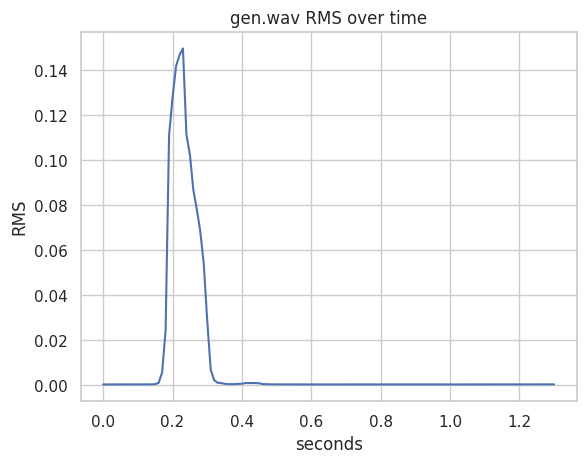

first 10 RMS: [0.00026578 0.00026166 0.00027068 0.00027075 0.00027413 0.00028491
 0.00028336 0.00029178 0.00029054 0.00029913]
median RMS: 0.000283096800558269 p95 RMS: 0.09463171660900116


In [125]:
# ============================================================
# END-TO-END: load tokens -> split -> silence-aware dataloaders -> train (+ optional continue)
# -> generate (safer sampling + repetition penalty) -> decode with per-file H (W fixed=20) -> listen + RMS plot
#
# Assumes you already have:
#   - vqvae (trained VQ-VAE model)
#   - tokens_to_wav(vqvae, tokens_1d, out_wav, H, W, mean_std_path)
#   - LOW_ENERGY_IDS (set of low-energy token IDs)
# ============================================================

import math
from pathlib import Path
from typing import List, Tuple, Optional
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display


# ============================================================
# 0) SETTINGS
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REAL_VOCAB = 128
PAD_ID = REAL_VOCAB
VOCAB_SIZE = REAL_VOCAB + 1

TOKENS_DIR = Path("/content/derived/tokens/vqvae")  # <-- change if needed
fallback_mean_std_path = TOKENS_DIR / "fallback_mean_std.npy"
assert fallback_mean_std_path.exists(), f"Missing: {fallback_mean_std_path}"

# IMPORTANT: your latent width is fixed at 20; H varies per file
W_FIXED = 20

# Training context length (window length)
SEQ_LEN = 512  # 256 if you want faster
BATCH_SIZE = 128
LR = 3e-4

N_EPOCHS = 5

NUM_WORKERS_TRAIN = 4
NUM_WORKERS_VAL = 2

TRAIN_SAMPLES_PER_EPOCH = 200_000
VAL_SAMPLES_PER_EPOCH = 50_000


# ============================================================
# 1) LOAD TOKENS
# ============================================================
def load_token_sequences(tokens_dir: Path, pad_id: int) -> List[np.ndarray]:
    paths = sorted(tokens_dir.glob("*_codes.npy"))
    if not paths:
        raise RuntimeError(f"No *_codes.npy files found in {tokens_dir}")

    seqs: List[np.ndarray] = []
    for p in paths:
        arr = np.load(p)
        arr = np.asarray(arr).reshape(-1)
        if arr.dtype != np.int64:
            arr = arr.astype(np.int64, copy=False)

        # if PAD appears, trim at first PAD (usually not present)
        pad_pos = np.where(arr == pad_id)[0]
        if len(pad_pos) > 0:
            arr = arr[: pad_pos[0]]

        if len(arr) >= 2:
            seqs.append(arr)

    if not seqs:
        raise RuntimeError("All sequences were empty after loading/trimming.")
    return seqs

sequences = load_token_sequences(TOKENS_DIR, PAD_ID)
print(f"Loaded {len(sequences)} sequences from {TOKENS_DIR}")


# ============================================================
# 2) TRAIN/VAL SPLIT (sequence-level; no leakage)
# ============================================================
val_frac = 0.1
num_sequences = len(sequences)
num_val = max(1, int(num_sequences * val_frac))

rng = np.random.default_rng(42)
all_idx = np.arange(num_sequences)
rng.shuffle(all_idx)

val_idx = all_idx[:num_val]
train_idx = all_idx[num_val:]

train_seqs = [sequences[i] for i in train_idx]
val_seqs = [sequences[i] for i in val_idx]
print(f"Train seqs: {len(train_seqs)} | Val seqs: {len(val_seqs)}")


# ============================================================
# 3) SILENCE-AWARE RANDOM WINDOW DATASET
# ============================================================
def estimate_silence_id(seqs, max_seqs: int = 500) -> int:
    cnt = Counter()
    for s in seqs[:max_seqs]:
        cnt.update(s.tolist())
    return cnt.most_common(1)[0][0]

SILENCE_ID = estimate_silence_id(train_seqs)
print("SILENCE_ID (most common token):", SILENCE_ID)

class SilenceAwareRandomWindowNextTokenDataset(Dataset):
    def __init__(
        self,
        sequences: List[np.ndarray],
        seq_len: int,
        samples_per_epoch: int,
        low_energy_ids: set,
        max_low_frac: float = 0.60,
        max_resample_tries: int = 30,
        seed: int = 123,
    ) -> None:
        self.seq_len = int(seq_len)
        self.samples_per_epoch = int(samples_per_epoch)

        self.low_energy_ids = set(int(x) for x in low_energy_ids)
        self.low_energy_ids_list = np.array(sorted(self.low_energy_ids), dtype=np.int64)

        self.max_low_frac = float(max_low_frac)
        self.max_resample_tries = int(max_resample_tries)
        self.rng = np.random.default_rng(seed)

        self.sequences = [s.astype(np.int64, copy=False) for s in sequences]
        self.valid = [i for i, s in enumerate(self.sequences) if len(s) > (self.seq_len + 1)]
        if not self.valid:
            raise RuntimeError("No sequences long enough for seq_len+1. Reduce SEQ_LEN.")

        weights = np.array([len(self.sequences[i]) - (self.seq_len + 1) for i in self.valid], dtype=np.float64)
        self.p = weights / weights.sum()

        print(
            f"SilenceAwareDataset: {len(self.valid)} valid seqs | seq_len={self.seq_len} | "
            f"samples/epoch={self.samples_per_epoch} | low_energy_ids={len(self.low_energy_ids)} | "
            f"max_low_frac={self.max_low_frac}"
        )

    def __len__(self) -> int:
        return self.samples_per_epoch

    def __getitem__(self, idx: int):
        last = None
        for _ in range(self.max_resample_tries):
            si = self.rng.choice(self.valid, p=self.p)
            seq = self.sequences[si]
            max_start = len(seq) - (self.seq_len + 1)
            start = int(self.rng.integers(0, max_start + 1))

            window = seq[start : start + self.seq_len + 1]
            xw = window[:-1]
            low_frac = float(np.mean(np.isin(xw, self.low_energy_ids_list)))
            last = (seq, start)

            if low_frac <= self.max_low_frac:
                break

        seq, start = last
        x = torch.from_numpy(seq[start : start + self.seq_len]).long()
        y = torch.from_numpy(seq[start + 1 : start + 1 + self.seq_len]).long()
        return x, y

train_dataset = SilenceAwareRandomWindowNextTokenDataset(
    train_seqs,
    seq_len=SEQ_LEN,
    samples_per_epoch=TRAIN_SAMPLES_PER_EPOCH,
    low_energy_ids=LOW_ENERGY_IDS,
    max_low_frac=0.60,
    seed=1
)

val_dataset = SilenceAwareRandomWindowNextTokenDataset(
    val_seqs,
    seq_len=SEQ_LEN,
    samples_per_epoch=VAL_SAMPLES_PER_EPOCH,
    low_energy_ids=LOW_ENERGY_IDS,
    max_low_frac=0.95,
    seed=2
)

def _seed_worker(worker_id):
    np.random.seed(1234 + worker_id)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS_TRAIN,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(NUM_WORKERS_TRAIN > 0),
    worker_init_fn=_seed_worker if NUM_WORKERS_TRAIN > 0 else None,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS_VAL,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(NUM_WORKERS_VAL > 0),
    worker_init_fn=_seed_worker if NUM_WORKERS_VAL > 0 else None,
)


# ============================================================
# 4) MODEL: CAUSAL TRANSFORMER LM
# ============================================================
class TransformerLM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,
        n_heads: int = 4,
        num_layers: int = 4,
        dim_feedforward: int = 512,
        max_seq_len: int = 512,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def _generate_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
        return torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L = x.shape
        if L > self.max_seq_len:
            raise ValueError(f"seq_len={L} exceeds max_seq_len={self.max_seq_len}")

        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        h = self.token_emb(x) + self.pos_emb(pos)

        attn_mask = self._generate_causal_mask(L, x.device)
        h = self.encoder(h, mask=attn_mask)

        h = self.ln_f(h)
        return self.head(h)

model = TransformerLM(
    vocab_size=VOCAB_SIZE,
    d_model=256,
    n_heads=4,
    num_layers=4,
    dim_feedforward=512,
    max_seq_len=SEQ_LEN,
    dropout=0.1,
).to(device)

print(model)


# ============================================================
# 5) TRAIN + OPTIONAL CONTINUE (early stopping + ReduceLROnPlateau)
# ============================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(x)  # (B, L, V)

        B, L, V = logits.shape
        logits_flat = logits.reshape(B * L, V)
        y_flat = y.reshape(B * L)

        mask = (y_flat != PAD_ID)
        n_valid = int(mask.sum().item())
        if n_valid == 0:
            continue

        loss = F.cross_entropy(logits_flat[mask], y_flat[mask])
        total_loss += loss.item() * n_valid
        total_tokens += n_valid

        preds = logits_flat.argmax(dim=-1)
        correct += int((preds[mask] == y_flat[mask]).sum().item())

    avg_loss = total_loss / max(1, total_tokens)
    acc = correct / max(1, total_tokens)
    return avg_loss, acc

def train_epochs(
    n_epochs: int,
    start_epoch: int = 1,
    best_val_loss: float = float("inf"),
    best_state: Optional[dict] = None,
    patience: int = 999999,      # huge = no early stop by default
    min_delta: float = 1e-3,
    save_path: Optional[Path] = None,
    use_scheduler: bool = False,
):
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=2,
            threshold=min_delta,
            threshold_mode="rel",
        )
    else:
        scheduler = None

    bad_epochs = 0

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        running_loss = 0.0
        running_tokens = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
                logits = model(x)
                B, L, V = logits.shape
                logits_flat = logits.reshape(B * L, V)
                y_flat = y.reshape(B * L)

                mask = (y_flat != PAD_ID)
                loss = F.cross_entropy(logits_flat[mask], y_flat[mask])

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            n_valid = int(mask.sum().item())
            running_loss += loss.item() * n_valid
            running_tokens += n_valid

        train_loss = running_loss / max(1, running_tokens)
        val_loss, val_acc = evaluate(model, val_loader)
        val_ppl = math.exp(val_loss) if np.isfinite(val_loss) else float("nan")

        if scheduler is not None and np.isfinite(val_loss):
            scheduler.step(val_loss)

        improved = np.isfinite(val_loss) and (val_loss < (best_val_loss - min_delta))
        if improved:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            bad_epochs = 0

            if save_path is not None:
                torch.save(
                    {
                        "model_state": best_state,
                        "best_val_loss": best_val_loss,
                        "epoch": epoch,
                        "vocab_size": VOCAB_SIZE,
                        "seq_len": SEQ_LEN,
                        "lr": optimizer.param_groups[0]["lr"],
                    },
                    save_path,
                )
        else:
            bad_epochs += 1

        lr_now = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
            f"val_ppl={val_ppl:.2f} | val_acc={val_acc:.4f} | lr={lr_now:.2e} | "
            f"bad_epochs={bad_epochs}/{patience if patience<999999 else '∞'}"
        )

        if bad_epochs >= patience:
            print(f"Early stopping: no val_loss improvement > {min_delta} for {patience} epochs.")
            break

    return best_val_loss, best_state

# ---- initial training ----
best_val_loss, best_state = train_epochs(
    n_epochs=N_EPOCHS,
    start_epoch=1,
    best_val_loss=float("inf"),
    best_state=None,
    patience=999999,
    min_delta=1e-3,
    save_path=None,
    use_scheduler=False,
)

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Loaded best model state (val_loss={best_val_loss:.4f}).")

# ---- optional continued training ----
EXTRA_EPOCHS = 10
PATIENCE = 3
MIN_DELTA = 1e-3
SAVE_PATH = Path("/content/derived/lm_best.pt")

best_val_loss, best_state = train_epochs(
    n_epochs=EXTRA_EPOCHS,
    start_epoch=N_EPOCHS + 1,
    best_val_loss=best_val_loss,
    best_state=best_state,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    save_path=SAVE_PATH,
    use_scheduler=True,
)

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Restored best model (val_loss={best_val_loss:.4f}). Saved to: {SAVE_PATH}")




Wrote: /content/real_decode.wav | seconds: 1.6533333333333333 | rms: 0.03849049285054207
[real] vqvae_10056_codes.npy | L=780 | H,W=(39,20) -> /content/real_decode.wav


Wrote: /content/gen.wav | seconds: 1.3546666666666667 | rms: 0.03005214035511017
[gen] L=640 | H,W=(32,20) -> /content/gen.wav


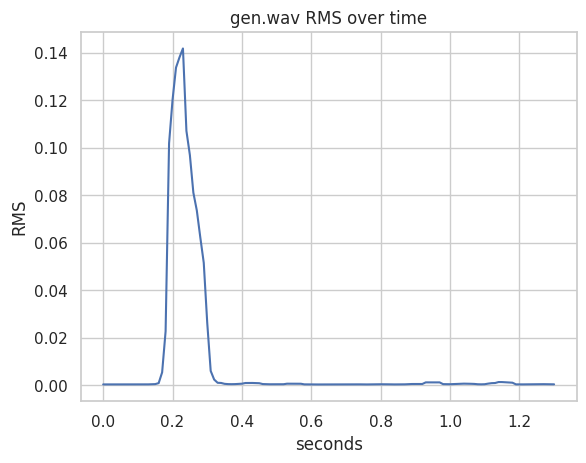

first 10 RMS: [0.00025052 0.00024951 0.00025424 0.00025509 0.00025625 0.00026831
 0.00026556 0.00027528 0.00027412 0.00028128]
median RMS: 0.000351436116034165 p95 RMS: 0.08890454471111298


In [134]:

# ============================================================
# 6) GENERATION (safer sampling + repetition penalty)
# ============================================================
def infer_H_from_len(L: int, W: int = 20) -> int:
    if L % W != 0:
        raise ValueError(f"Token length {L} not divisible by W={W}")
    return L // W

@torch.no_grad()
@torch.no_grad()
def generate_tokens_safe(
    model: nn.Module,
    prompt: torch.Tensor,          # (1, L0) LongTensor
    max_new_tokens: int,
    temperature: float = 0.7,
    top_k: int = 20,
    rep_penalty: float = 0.7,
    rep_window: int = 128,
    row_width: int = 20,           # <-- W (fixed latent width)
    anti_copy: float = 1.2,        # <-- penalize copying token from t-row_width
    rows_back: int = 1,            # <-- set to 3–6 to penalize several previous rows
) -> torch.Tensor:
    model.eval()
    x = prompt.to(device)

    for _ in range(max_new_tokens):
        x_cond = x[:, -model.max_seq_len:]

        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(x_cond)          # (1, L, V)
            next_logits = logits[:, -1, :]  # (1, V)

        # never sample PAD
        next_logits[:, PAD_ID] = float("-inf")

        # repetition penalty (kills short buzz loops)
        if rep_penalty > 0 and x.size(1) > 0:
            recent = x[0, -min(rep_window, x.size(1)):].tolist()
            if recent:
                next_logits[0, recent] -= rep_penalty

        # NEW: anti-copy from previous row(s): discourages x[t] == x[t-row_width]
        if anti_copy > 0 and row_width > 0:
            max_k = min(int(rows_back), x.size(1) // row_width)
            for k in range(1, max_k + 1):
                tok = int(x[0, -(k * row_width)].item())
                next_logits[0, tok] -= float(anti_copy)

        # temperature
        next_logits = next_logits / max(float(temperature), 1e-8)

        # top-k
        if top_k is not None and top_k > 0:
            k = min(int(top_k), next_logits.size(-1))
            v, ix = torch.topk(next_logits, k=k, dim=-1)
            filt = torch.full_like(next_logits, float("-inf"))
            filt.scatter_(1, ix, v)
            next_logits = filt

        probs = F.softmax(next_logits, dim=-1)
        next_tok = torch.multinomial(probs, num_samples=1)  # (1, 1)
        x = torch.cat([x, next_tok], dim=1)

    return x


# ============================================================
# 7) REAL DECODE SANITY CHECK + GENERATE MATCHED LENGTH + DECODE + RMS
# ============================================================

# --- sanity check: decode a real codes file ---
real_p = sorted(TOKENS_DIR.glob("*_codes.npy"))[0]
real_codes = np.load(real_p).astype(np.int64).reshape(-1)
H_real = infer_H_from_len(len(real_codes), W_FIXED)

tokens_to_wav(
    vqvae=vqvae,
    tokens_1d=real_codes,
    out_wav="/content/real_decode.wav",
    H=H_real,
    W=W_FIXED,
    mean_std_path=fallback_mean_std_path,
)
print(f"[real] {real_p.name} | L={len(real_codes)} | H,W=({H_real},{W_FIXED}) -> /content/real_decode.wav")
display(Audio("/content/real_decode.wav"))

# --- generate: match length of a real training sequence ---
target_seq = np.asarray(train_seqs[0], dtype=np.int64).reshape(-1)
L = len(target_seq)
H = infer_H_from_len(L, W_FIXED)

PROMPT_LEN = min(256, L - 1)   # longer prompt helps a LOT vs 32
prompt = torch.from_numpy(target_seq[:PROMPT_LEN]).long().unsqueeze(0)
max_new = int(L_total - prompt.size(1))
out = generate_tokens_safe(
    model=model,
    prompt=prompt,
    max_new_tokens=max_new,
    temperature=0.75,
    top_k=25,
    rep_penalty=1.0,
    rep_window=128,
    row_width=W,
    anti_copy=1.2,
    rows_back=4,
)

gen_tokens = out.squeeze(0).detach().cpu().numpy()[:L].astype(np.int64, copy=False)

tokens_to_wav(
    vqvae=vqvae,
    tokens_1d=gen_tokens,
    out_wav="/content/gen.wav",
    H=H,
    W=W_FIXED,
    mean_std_path=fallback_mean_std_path,
)

print(f"[gen] L={L} | H,W=({H},{W_FIXED}) -> /content/gen.wav")
display(Audio("/content/gen.wav"))

# --- RMS plot for gen.wav ---
y, sr = sf.read("/content/gen.wav")
y = y.astype(np.float32)

win = int(0.05 * sr)   # 50 ms
hop = int(0.01 * sr)   # 10 ms

rms = np.array([np.sqrt(np.mean(y[i:i+win]**2)) for i in range(0, len(y)-win, hop)], dtype=np.float32)
t = np.arange(len(rms)) * hop / sr

plt.figure()
plt.plot(t, rms)
plt.xlabel("seconds")
plt.ylabel("RMS")
plt.title("gen.wav RMS over time")
plt.show()

print("first 10 RMS:", rms[:10])
print("median RMS:", float(np.median(rms)), "p95 RMS:", float(np.percentile(rms, 95)))

In [136]:
# Generate LONG audio by stitching segments (anti-chainsaw)

import numpy as np
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display

W = 20
fallback_mean_std_path = Path(TOKENS_DIR) / "fallback_mean_std.npy"

# Sampling (good defaults)
TEMPERATURE = 0.75
TOP_K = 25
REP_PENALTY = 1.0
REP_WINDOW = 128
ROW_WIDTH = 20
ANTI_COPY = 1.2
ROWS_BACK = 4
PROMPT_LEN = 256

# Length control
N_SEGMENTS = 6            # how many chunks to stitch
SEG_ROWS = 39             # 39 rows × 20 = 780 tokens per segment
SEG_TOKENS = SEG_ROWS * W

def infer_H(L, W=20):
    assert L % W == 0
    return L // W

segments_audio = []
sr = None

base_seq = np.asarray(train_seqs[0], dtype=np.int64)

for seg in range(N_SEGMENTS):
    # prompt from real data (middle is often better)
    Lp = min(PROMPT_LEN, len(base_seq) - 1)
    prompt_np = base_seq[:Lp]
    prompt = torch.from_numpy(prompt_np).long().unsqueeze(0)

    max_new = int(SEG_TOKENS - prompt.size(1))
    if max_new <= 0:
        raise ValueError("PROMPT_LEN too long for SEG_TOKENS")

    out = generate_tokens_safe(
        model=model,
        prompt=prompt,
        max_new_tokens=max_new,
        temperature=TEMPERATURE,
        top_k=TOP_K,
        rep_penalty=REP_PENALTY,
        rep_window=REP_WINDOW,
        row_width=ROW_WIDTH,
        anti_copy=ANTI_COPY,
        rows_back=ROWS_BACK,
    )

    toks = out.squeeze(0).cpu().numpy()[:SEG_TOKENS].astype(np.int64, copy=False)

    H = infer_H(len(toks), W)
    seg_wav = f"/content/seg_{seg}.wav"

    tokens_to_wav(
        vqvae=vqvae,
        tokens_1d=toks,
        out_wav=seg_wav,
        H=H,
        W=W,
        mean_std_path=fallback_mean_std_path,
    )

    y, sr = sf.read(seg_wav)
    segments_audio.append(y)

    print(f"[segment {seg}] tokens={len(toks)} H={H}")

# Stitch all segments
y_full = np.concatenate(segments_audio, axis=0)
out_full = "/content/gen_long.wav"
sf.write(out_full, y_full, sr)

print("Wrote:", out_full, "seconds:", len(y_full) / sr)
display(Audio(out_full))


Wrote: /content/seg_0.wav | seconds: 1.6533333333333333 | rms: 0.03556192293763161
[segment 0] tokens=780 H=39
Wrote: /content/seg_1.wav | seconds: 1.6533333333333333 | rms: 0.023567402735352516
[segment 1] tokens=780 H=39
Wrote: /content/seg_2.wav | seconds: 1.6533333333333333 | rms: 0.03532690927386284
[segment 2] tokens=780 H=39
Wrote: /content/seg_3.wav | seconds: 1.6533333333333333 | rms: 0.037216465920209885
[segment 3] tokens=780 H=39
Wrote: /content/seg_4.wav | seconds: 1.6533333333333333 | rms: 0.04399249702692032
[segment 4] tokens=780 H=39
Wrote: /content/seg_5.wav | seconds: 1.6533333333333333 | rms: 0.036293525248765945
[segment 5] tokens=780 H=39
Wrote: /content/gen_long.wav seconds: 9.92


In [145]:
@torch.no_grad()
def generate_tokens_scheduled(
    model, prompt, max_new_tokens,
    row_width=20, anti_copy=1.2, rows_back=4,
    rep_penalty=1.0, rep_window=128,
    t0=0.70, k0=25,         # stable phase
    t1=0.90, k1=60,         # detail phase
    switch_frac=0.35,       # after 35% tokens, allow more detail
):
    model.eval()
    x = prompt.to(device)

    for step in range(int(max_new_tokens)):
        frac = step / max(1, max_new_tokens-1)
        temperature = t0 if frac < switch_frac else t1
        top_k = k0 if frac < switch_frac else k1

        x_cond = x[:, -model.max_seq_len:]
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(x_cond)
            next_logits = logits[:, -1, :]

        next_logits[:, PAD_ID] = float("-inf")

        # rep penalty
        if rep_penalty > 0 and x.size(1) > 0:
            recent = x[0, -min(rep_window, x.size(1)):].tolist()
            if recent:
                next_logits[0, recent] -= rep_penalty

        # anti-copy from previous row(s)
        if anti_copy > 0 and row_width > 0:
            max_k = min(int(rows_back), x.size(1) // row_width)
            for k in range(1, max_k + 1):
                tok = int(x[0, -(k * row_width)].item())
                next_logits[0, tok] -= float(anti_copy)

        # temperature
        next_logits = next_logits / max(float(temperature), 1e-8)

        # top-k
        if top_k is not None and top_k > 0:
            k = min(int(top_k), next_logits.size(-1))
            v, ix = torch.topk(next_logits, k=k, dim=-1)
            filt = torch.full_like(next_logits, float("-inf"))
            filt.scatter_(1, ix, v)
            next_logits = filt

        probs = F.softmax(next_logits, dim=-1)
        next_tok = torch.multinomial(probs, 1)
        x = torch.cat([x, next_tok], dim=1)

    return x

# ============================================================
# Generate + Decode audio using generate_tokens_scheduled
# ============================================================
import numpy as np
from pathlib import Path
import soundfile as sf
from IPython.display import Audio, display

W = 20
fallback_mean_std_path = Path(TOKENS_DIR) / "fallback_mean_std.npy"

def infer_H(L, W=20):
    assert L % W == 0, f"L={L} not divisible by W={W}"
    return L // W

# ----------------------------
# Choose a real sequence for length + prompt
# ----------------------------
target_seq = np.asarray(train_seqs[0], dtype=np.int64)
L_total = (len(target_seq) // W) * W   # ensure multiple of 20
H = infer_H(L_total, W)

PROMPT_LEN = min(256, L_total - 1)
prompt = torch.from_numpy(target_seq[:PROMPT_LEN]).long().unsqueeze(0)

# ----------------------------
# Generate tokens (scheduled sampling)
# ----------------------------
out = generate_tokens_scheduled(
    model=model,
    prompt=prompt,
    max_new_tokens=int(L_total - prompt.size(1)),
    row_width=W,
    anti_copy=1.2,
    rows_back=4,
    rep_penalty=1.0,
    rep_window=128,
    t0=0.80, k0=40,      # stable phase
    t1=1.10, k1=20,      # detail phase
    switch_frac=0.20,
)

gen_tokens = (
    out.squeeze(0)
       .detach()
       .cpu()
       .numpy()[:L_total]
       .astype(np.int64, copy=False)
)

# ----------------------------
# Decode tokens → waveform
# ----------------------------
out_wav = "/content/gen.wav"
tokens_to_wav(
    vqvae=vqvae,
    tokens_1d=gen_tokens,
    out_wav=out_wav,
    H=H,
    W=W,
    mean_std_path=fallback_mean_std_path,
)

print(f"Wrote {out_wav} | H={H}, W={W}, tokens={len(gen_tokens)}")
display(Audio(out_wav))


Wrote: /content/gen.wav | seconds: 1.3546666666666667 | rms: 0.034987736493349075
Wrote /content/gen.wav | H=32, W=20, tokens=640


Wrote: /content/gen.wav | seconds: 1.3546666666666667 | rms: 0.0406249538064003
Wrote /content/gen.wav | H=32, W=20, tokens=640


repeat2: 0.050156739811912224 repeat20: 0.056451612903225805


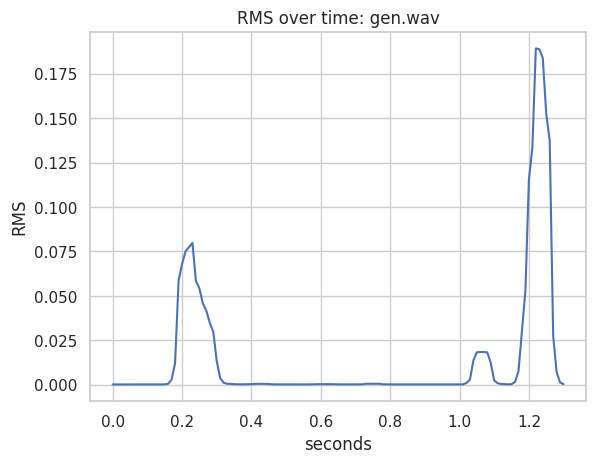

median RMS: 0.00023350185074377805 p95 RMS: 0.09765085577964783


In [154]:
# ============================================================
# Scheduled sampling generator + decode + RMS plot
# Assumes you already have:
#   - model, vqvae, train_seqs, TOKENS_DIR, PAD_ID, device
#   - tokens_to_wav(vqvae, tokens_1d, out_wav, H, W, mean_std_path)
# ============================================================

import numpy as np
from pathlib import Path
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn.functional as F


@torch.no_grad()
def generate_tokens_scheduled(
    model,
    prompt: torch.Tensor,          # (1, L0) LongTensor
    max_new_tokens: int,
    *,
    row_width: int = 20,
    anti_copy: float = 1.2,
    rows_back: int = 4,
    rep_penalty: float = 1.0,
    rep_window: int = 128,
    t0: float = 0.70,              # stable phase temperature
    k0: int = 25,                  # stable phase top-k
    t1: float = 0.90,              # detail phase temperature
    k1: int = 60,                  # detail phase top-k
    switch_frac: float = 0.35,     # after this fraction of steps, switch to detail phase
) -> torch.Tensor:
    model.eval()
    x = prompt.to(device)

    max_new_tokens = int(max_new_tokens)
    if max_new_tokens <= 0:
        return x

    for step in range(max_new_tokens):
        frac = step / max(1, max_new_tokens - 1)
        temperature = t0 if frac < switch_frac else t1
        top_k = k0 if frac < switch_frac else k1

        x_cond = x[:, -model.max_seq_len:]

        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(x_cond)          # (1, L, V)
            next_logits = logits[:, -1, :]  # (1, V)

        # never sample PAD
        next_logits[:, PAD_ID] = float("-inf")

        # repetition penalty (discourage recent tokens)
        if rep_penalty > 0 and x.size(1) > 0:
            recent = x[0, -min(rep_window, x.size(1)):].tolist()
            if recent:
                next_logits[0, recent] -= float(rep_penalty)

        # anti-copy from previous row(s): discourage x[t] == x[t-row_width]
        if anti_copy > 0 and row_width > 0:
            max_k = min(int(rows_back), x.size(1) // row_width)
            for k in range(1, max_k + 1):
                tok = int(x[0, -(k * row_width)].item())
                next_logits[0, tok] -= float(anti_copy)

        # temperature
        next_logits = next_logits / max(float(temperature), 1e-8)

        # top-k filter
        if top_k is not None and int(top_k) > 0:
            kk = min(int(top_k), next_logits.size(-1))
            v, ix = torch.topk(next_logits, k=kk, dim=-1)
            filt = torch.full_like(next_logits, float("-inf"))
            filt.scatter_(1, ix, v)
            next_logits = filt

        probs = F.softmax(next_logits, dim=-1)
        next_tok = torch.multinomial(probs, num_samples=1)  # (1, 1)
        x = torch.cat([x, next_tok], dim=1)

    return x


def infer_H(L: int, W: int = 20) -> int:
    if L % W != 0:
        raise ValueError(f"L={L} not divisible by W={W}")
    return L // W


def plot_rms(wav_path: str, win_ms: float = 50.0, hop_ms: float = 10.0) -> None:
    y, sr = sf.read(wav_path)
    y = y.astype(np.float32)

    win = max(1, int(sr * (win_ms / 1000.0)))
    hop = max(1, int(sr * (hop_ms / 1000.0)))

    if len(y) < win:
        print("Audio too short for RMS window.")
        return

    rms = np.array(
        [np.sqrt(np.mean(y[i:i+win]**2)) for i in range(0, len(y) - win, hop)],
        dtype=np.float32
    )
    t = np.arange(len(rms)) * hop / sr

    plt.figure()
    plt.plot(t, rms)
    plt.xlabel("seconds")
    plt.ylabel("RMS")
    plt.title(f"RMS over time: {Path(wav_path).name}")
    plt.show()

    print("median RMS:", float(np.median(rms)), "p95 RMS:", float(np.percentile(rms, 95)))


# ============================================================
# Generate + decode + play + RMS
# ============================================================
W = 20
fallback_mean_std_path = Path(TOKENS_DIR) / "fallback_mean_std.npy"

target_seq = np.asarray(train_seqs[0], dtype=np.int64)
L_total = (len(target_seq) // W) * W
H = infer_H(L_total, W)

PROMPT_LEN = min(256, L_total - 1)
prompt = torch.from_numpy(target_seq[:PROMPT_LEN]).long().unsqueeze(0)

out = generate_tokens_scheduled(
    model=model,
    prompt=prompt,
    max_new_tokens=int(L_total - prompt.size(1)),
    row_width=W,
    anti_copy=1.2,
    rows_back=4,
    rep_penalty=1.0,
    rep_window=128,
    t0=0.80, k0=40,      # stable phase
    t1=1.10, k1=20,      # detail phase
    switch_frac=0.20,
)

gen_tokens = out.squeeze(0).detach().cpu().numpy()[:L_total].astype(np.int64, copy=False)

out_wav = "/content/gen.wav"
tokens_to_wav(
    vqvae=vqvae,
    tokens_1d=gen_tokens,
    out_wav=out_wav,
    H=H,
    W=W,
    mean_std_path=fallback_mean_std_path,
)

print(f"Wrote {out_wav} | H={H}, W={W}, tokens={len(gen_tokens)}")
display(Audio(out_wav))

# Optional: quick loop diagnostics
repeat2 = float(np.mean(gen_tokens[2:] == gen_tokens[:-2])) if len(gen_tokens) > 2 else float("nan")
repeat20 = float(np.mean(gen_tokens[W:] == gen_tokens[:-W])) if len(gen_tokens) > W else float("nan")
print("repeat2:", repeat2, "repeat20:", repeat20)

# RMS plot
plot_rms(out_wav, win_ms=50.0, hop_ms=10.0)


Wrote: /content/real_0.wav | seconds: 1.6533333333333333 | rms: 0.03916853293776512
[real 0] vqvae_10056_codes.npy | H=39, W=20, tokens=780


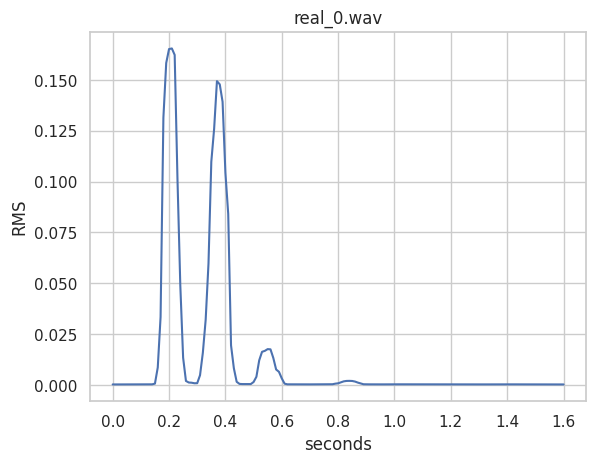

median RMS: 0.00027043739100918174 p95 RMS: 0.12590017914772034
Wrote: /content/real_1.wav | seconds: 1.312 | rms: 0.020344769582152367
[real 1] vqvae_10083_codes.npy | H=31, W=20, tokens=620


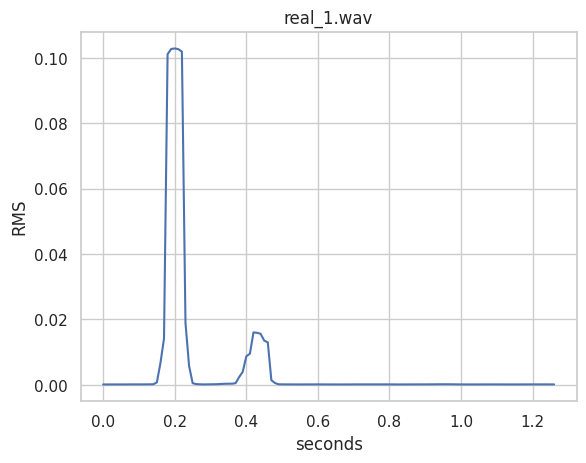

median RMS: 0.00013531945296563208 p95 RMS: 0.01600678265094757
Wrote: /content/real_2.wav | seconds: 1.568 | rms: 0.06832975149154663
[real 2] vqvae_10253_codes.npy | H=37, W=20, tokens=740


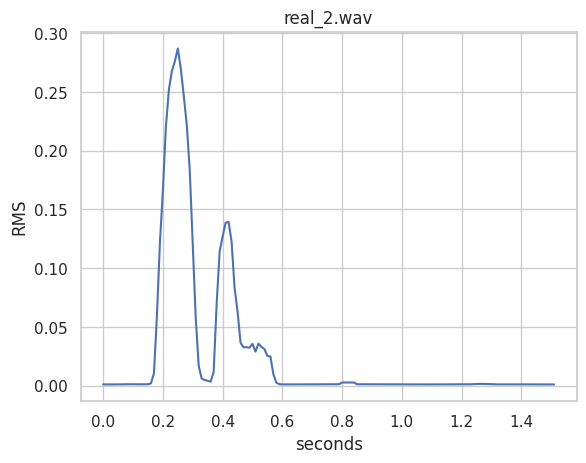

median RMS: 0.0011387425474822521 p95 RMS: 0.1995784342288971


In [151]:
# ============================================================
# Decode REAL samples + RMS plots
# ============================================================
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio, display

W = 20
fallback_mean_std_path = Path(TOKENS_DIR) / "fallback_mean_std.npy"

def infer_H(L: int, W: int = 20) -> int:
    if L % W != 0:
        raise ValueError(f"L={L} not divisible by W={W}")
    return L // W

def plot_rms_from_wav(wav_path: str, win_ms: float = 50.0, hop_ms: float = 10.0):
    y, sr = sf.read(wav_path)
    y = y.astype(np.float32)

    win = max(1, int(sr * win_ms / 1000))
    hop = max(1, int(sr * hop_ms / 1000))

    rms = np.array(
        [np.sqrt(np.mean(y[i:i+win]**2)) for i in range(0, len(y)-win, hop)],
        dtype=np.float32
    )
    t = np.arange(len(rms)) * hop / sr

    plt.figure()
    plt.plot(t, rms)
    plt.xlabel("seconds")
    plt.ylabel("RMS")
    plt.title(Path(wav_path).name)
    plt.show()

    print("median RMS:", float(np.median(rms)),
          "p95 RMS:", float(np.percentile(rms, 95)))

# ------------------------------------------------------------
# Decode + plot a few real samples
# ------------------------------------------------------------
N_REAL = 3   # how many real samples to inspect

code_paths = sorted(TOKENS_DIR.glob("*_codes.npy"))[:N_REAL]

for i, p in enumerate(code_paths):
    codes = np.load(p).astype(np.int64).reshape(-1)
    L = (len(codes) // W) * W
    codes = codes[:L]
    H = infer_H(L, W)

    out_wav = f"/content/real_{i}.wav"

    tokens_to_wav(
        vqvae=vqvae,
        tokens_1d=codes,
        out_wav=out_wav,
        H=H,
        W=W,
        mean_std_path=fallback_mean_std_path,
    )

    print(f"[real {i}] {p.name} | H={H}, W={W}, tokens={L}")
    display(Audio(out_wav))

    plot_rms_from_wav(out_wav, win_ms=50.0, hop_ms=10.0)
